In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json

import sys

sys.path.append("../")

##################################################################
os.environ["TOKENIZERS_PARALLELISM"] = "false"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"
##################################################################

import logging
from src.utils import logging_utils
from src.utils import env_utils

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(
    f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}"
)
logger.info(f"{transformers.__version__=}")

2025-08-14 19:07:33 __main__ INFO     torch.__version__='2.7.0+cu126', torch.version.cuda='12.6'
2025-08-14 19:07:34 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=8, torch.cuda.get_device_name()='NVIDIA A100 80GB PCIe'
2025-08-14 19:07:34 __main__ INFO     transformers.__version__='4.54.1'


In [3]:
from src.utils.training_utils import get_device_map

# model_key = "meta-llama/Llama-3.2-3B"
# model_key = "meta-llama/Llama-3.1-8B"
model_key = "meta-llama/Llama-3.3-70B-Instruct"
# model_key = "meta-llama/Llama-3.1-405B-Instruct"

# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-3-12b-it"
# model_key = "google/gemma-2-27b-it"

# model_key = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

# model_key = "allenai/OLMo-2-1124-7B-Instruct"
# model_key = "allenai/OLMo-7B-0424-hf"

# model_key = "Qwen/Qwen2-7B"
# model_key = "Qwen/Qwen2.5-14B-Instruct"
# model_key = "Qwen/Qwen2.5-32B-Instruct"
# model_key = "Qwen/Qwen2.5-72B-Instruct"

# model_key = "Qwen/Qwen3-1.7B"
# model_key = "Qwen/Qwen3-4B"
# model_key = "Qwen/Qwen3-8B"
# model_key = "Qwen/Qwen3-14B"
# model_key = "Qwen/Qwen3-32B"

# device_map = get_device_map(model_key, 30, n_gpus=8)
# device_map

2025-08-14 19:07:36 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-08-14 19:07:36 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-08-14 19:07:37 wandb.docker.auth DEBUG    Trying paths: ['/disk/u/arnab/.docker/config.json', '/disk/u/arnab/.dockercfg']
2025-08-14 19:07:37 wandb.docker.auth DEBUG    No config file found


In [4]:
from src.models import ModelandTokenizer

# from transformers import BitsAndBytesConfig

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.bfloat16,
    # device_map=device_map,
    device_map="auto",
    # quantization_config = BitsAndBytesConfig(
    #     # load_in_4bit=True
    #     load_in_8bit=True
    # )
    attn_implementation="eager",
)

2025-08-14 19:07:37 src.models WARNING  meta-llama/Llama-3.3-70B-Instruct not found in /disk/u/arnab/Codes/Models
If not found in cache, model will be downloaded from HuggingFace to cache directory
2025-08-14 19:07:37 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:443


2025-08-14 19:07:37 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/config.json HTTP/1.1" 200 0
2025-08-14 19:07:37 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2025-08-14 19:07:37 urllib3.connectionpool DEBUG    https://huggingface.co:443 "GET /api/models/meta-llama/Llama-3.3-70B-Instruct/tree/main/additional_chat_templates?recursive=False&expand=False HTTP/1.1" 404 64


Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

2025-08-14 19:08:24 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/generation_config.json HTTP/1.1" 200 0
2025-08-14 19:08:24 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/custom_generate/generate.py HTTP/1.1" 404 0
2025-08-14 19:08:24 src.models INFO     loaded model <meta-llama/Llama-3.3-70B-Instruct> | size: 134570.516 MB | dtype: torch.bfloat16 | device: cuda:0


In [5]:
from typing import Optional
from src.selection.data import SelectionSample
from src.tokens import prepare_input


from src.functional import (
    get_module_nnsight,
    PatchSpec,
    interpret_logits,
    patch_with_baukit,
)
from src.selection.functional import get_first_token_id
from src.utils.typing import TokenizerOutput
from src.attention import get_attention_matrices
from src.selection.functional import (
    verify_head_patterns,
    cache_q_projections,
    validate_q_proj_ie_on_sample_pair,
)

## Loading the heads

### Attention Behavior

In [7]:
from scripts.locate_resolution_heads import SelectionSampleAttn
from tqdm import tqdm
attn_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/attention_patterns",
    "select_odd_one_out",
    mt.name.split("/")[-1],
    "objects"
)
files = sorted(os.listdir(attn_path))

#######################################################################
# LIMIT = 100
LIMIT = len(files)
#######################################################################

selection_attns = []

for npz_file in tqdm(files[:LIMIT]):
    if not npz_file.endswith(".npz"):
        continue

    npz_path = os.path.join(attn_path, npz_file)
    selection_attns.append(SelectionSampleAttn.from_npz(npz_path))
    # if len(selection_attns) % 10 == 0:
    #     print(f"Loaded {len(selection_attns)}/{LIMIT} files")

len(selection_attns)

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [01:27<00:00,  5.71it/s]


500

In [8]:
from src.attention import visualize_attn_matrix

sample_idx = 18
# layer_idx = 39
# head_idx = 40
layer_idx = 35
head_idx = 19

selection_attn = selection_attns[sample_idx]
print(selection_attn.resolution_score(layer_idx, head_idx))
visualize_attn_matrix(
    attn_matrix=selection_attn.attention_pattern.attention_matrices[layer_idx, head_idx],
    tokens=selection_attn.attention_pattern.tokenized_prompt,
    q_index=-1,
    start_from=1,
)

(0.43115234375, 0.513671875, [0.0191650390625, 0.08251953125, 0.0291748046875, 0.00576019287109375, 0.0330810546875])


In [9]:
from tqdm.auto import tqdm

#############################################################################
n_layer = mt.n_layer
n_head = mt.config.num_attention_heads
# token_idx = "all"
token_idx = "last"
##############################################################################

resolution_scores = torch.zeros((n_head, n_layer), dtype=torch.float32)
for selection_attn in tqdm(selection_attns):
    for layer_idx in range(n_layer):
        for head_idx in range(n_head):
            resolution_scores[head_idx, layer_idx] += selection_attn.resolution_score(
                layer_idx, head_idx, token_idx=token_idx
            )[0]
            # resolution_scores[head_idx, layer_idx] += selection_attn.first_token_score(
            #     layer_idx, head_idx
            # )[0]

resolution_scores /= len(selection_attns)
resolution_scores.shape

  0%|          | 0/500 [00:00<?, ?it/s]

torch.Size([64, 80])

2025-08-13 15:29:17 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fa0a6922310>


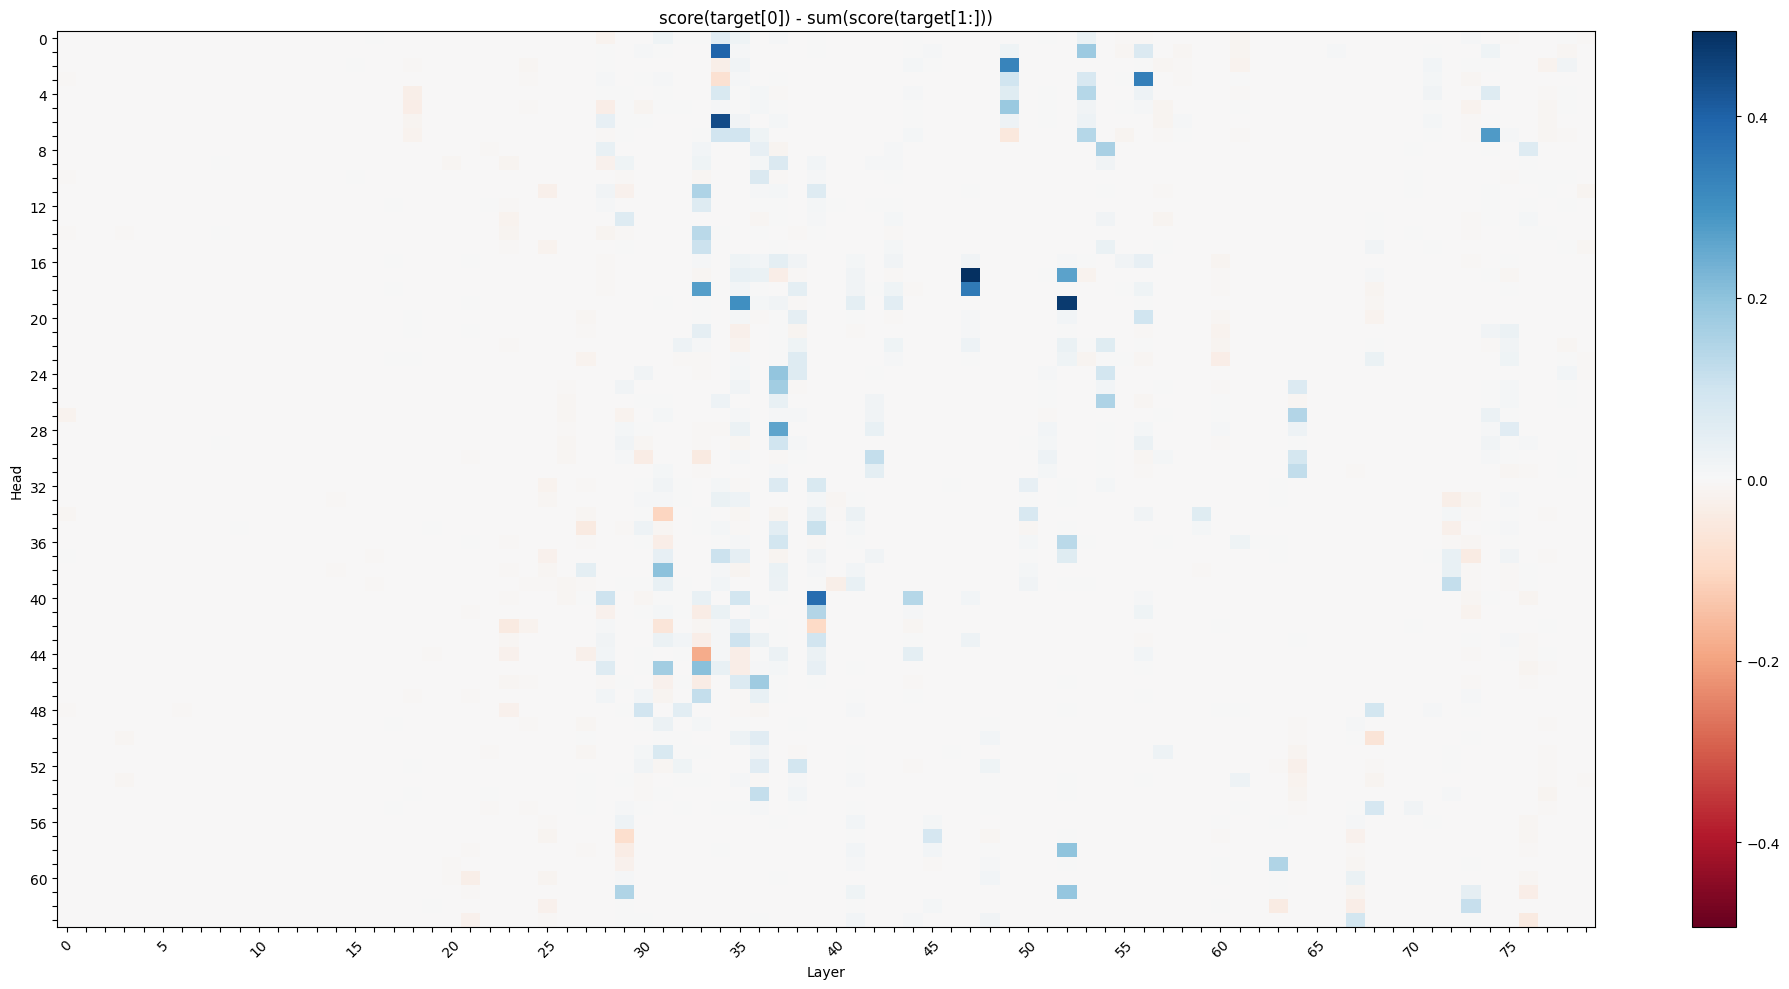

Layer 47, Head 17: 0.4938
Layer 52, Head 19: 0.4722
Layer 34, Head 6: 0.4414
Layer 34, Head 1: 0.3971
Layer 39, Head 40: 0.3761
Layer 47, Head 18: 0.3488
Layer 56, Head 3: 0.3390
Layer 49, Head 2: 0.3267
Layer 35, Head 19: 0.3034
Layer 74, Head 7: 0.2802
Layer 33, Head 18: 0.2732
Layer 52, Head 17: 0.2655
Layer 37, Head 28: 0.2613
Layer 33, Head 45: 0.2051
Layer 31, Head 38: 0.2024


In [11]:
from matplotlib import pyplot as plt

plt.figure(figsize=(20, 10))
scale = torch.max(torch.abs(resolution_scores))
plt.imshow(
    resolution_scores.cpu().numpy(),
    cmap="RdBu",
    aspect="auto",
    vmin=-scale,
    vmax=scale,
)
plt.colorbar()
# plt.title(f"score(target) - max(score(distractors)) | {token_idx.upper()} tokens of options")
plt.title("score(target[0]) - sum(score(target[1:]))")
plt.xlabel("Layer")
plt.ylabel("Head")

def get_ticks(ticks, skip=5):
    ret = []
    for i in ticks:
        if i % skip == 0:
            ret.append(str(i))
        else:
            ret.append("")
    return ret

plt.xticks(
    ticks=range(n_layer),
    labels=get_ticks(range(n_layer)),
    rotation=45,
)
plt.yticks(
    ticks=range(n_head),
    labels=get_ticks(range(n_head), skip=4),
)

plt.tight_layout()
plt.show()


scores_per_head = []
for head_idx in range(n_head):
    for layer_idx in range(n_layer):
        scores_per_head.append(
            (head_idx, layer_idx, resolution_scores[head_idx, layer_idx].item())
        )

scores_per_head = sorted(scores_per_head, key=lambda x: x[2], reverse=True)
for head_idx, layer_idx, score in scores_per_head[:15]:
    print(f"Layer {layer_idx}, Head {head_idx}: {score:.4f}")

In [197]:
HEADS = [
    (33, 45),
    (33, 18),
    (34, 1),
    (34, 6),
    (34, 7),
    (35, 19),
    (39, 40),
    (42, 30),
    (47, 18),
    (52, 58),
]

# with open("optimized_heads.json", "r") as f:
#     HEADS = json.load(f)

# with open("category_wise_heads.json", "r") as f:
#     category_wise_heads = json.load(f)
# HEADS = [
#     (layer_idx, head_idx)
#     for layer_idx, head_idx, score in category_wise_heads["all"][:50]
# ]

# print(len(HEADS))

# HEADS = [(layer_idx, head_idx) for head_idx, layer_idx, score in scores_per_head[:10]]
HEADS = heads_selected
print(HEADS)

[(24, 3), (25, 32), (26, 25), (26, 26), (26, 30), (26, 39), (27, 17), (27, 34), (27, 35), (28, 0), (28, 2), (28, 9), (28, 20), (28, 31), (28, 41), (28, 45), (29, 8), (29, 11), (29, 12), (29, 25), (29, 58), (29, 61), (29, 62), (30, 24), (30, 28), (30, 48), (30, 53), (30, 54), (30, 57), (30, 62), (31, 7), (31, 32), (31, 34), (31, 36), (31, 37), (31, 38), (31, 39), (31, 41), (31, 43), (31, 47), (31, 49), (31, 51), (31, 52), (32, 0), (32, 2), (32, 12), (32, 19), (32, 21), (32, 23), (32, 48), (32, 52), (32, 57), (33, 11), (33, 15), (33, 18), (33, 21), (33, 23), (33, 30), (33, 41), (33, 42), (33, 44), (33, 45), (33, 46), (33, 47), (33, 48), (33, 49), (33, 53), (33, 54), (34, 1), (34, 2), (34, 3), (34, 4), (34, 6), (34, 7), (34, 17), (34, 23), (34, 26), (34, 35), (34, 36), (34, 37), (34, 38), (34, 41), (34, 43), (34, 45), (34, 46), (34, 55), (35, 0), (35, 4), (35, 6), (35, 7), (35, 17), (35, 18), (35, 19), (35, 20), (35, 21), (35, 22), (35, 23), (35, 24), (35, 27), (35, 28), (35, 29), (35, 33

### Load the optimzied heads

In [6]:
from matplotlib import pyplot as plt
import numpy as np

optimized_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/optimized_heads",
    mt.name.split("/")[-1],
    "odd_one_out__not_patch_category.npz"
)

optimization_results = np.load(optimized_path, allow_pickle=True)
plt.plot(optimization_results["losses"])
plt.show()

2025-08-14 19:08:36 matplotlib DEBUG    matplotlib data path: /disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/matplotlib/mpl-data
2025-08-14 19:08:36 matplotlib DEBUG    CONFIGDIR=/disk/u/arnab/.config/matplotlib
2025-08-14 19:08:36 matplotlib DEBUG    interactive is False
2025-08-14 19:08:36 matplotlib DEBUG    platform is linux
2025-08-14 19:08:36 matplotlib DEBUG    CACHEDIR=/disk/u/arnab/.cache/matplotlib
2025-08-14 19:08:36 matplotlib.font_manager DEBUG    Using fontManager instance from /disk/u/arnab/.cache/matplotlib/fontlist-v390.json


FileNotFoundError: [Errno 2] No such file or directory: '/disk/u/arnab/Codes/Projects/retrieval/results/selection/optimized_heads/Llama-3.3-70B-Instruct/odd_one_out__not_patch_category.npz'

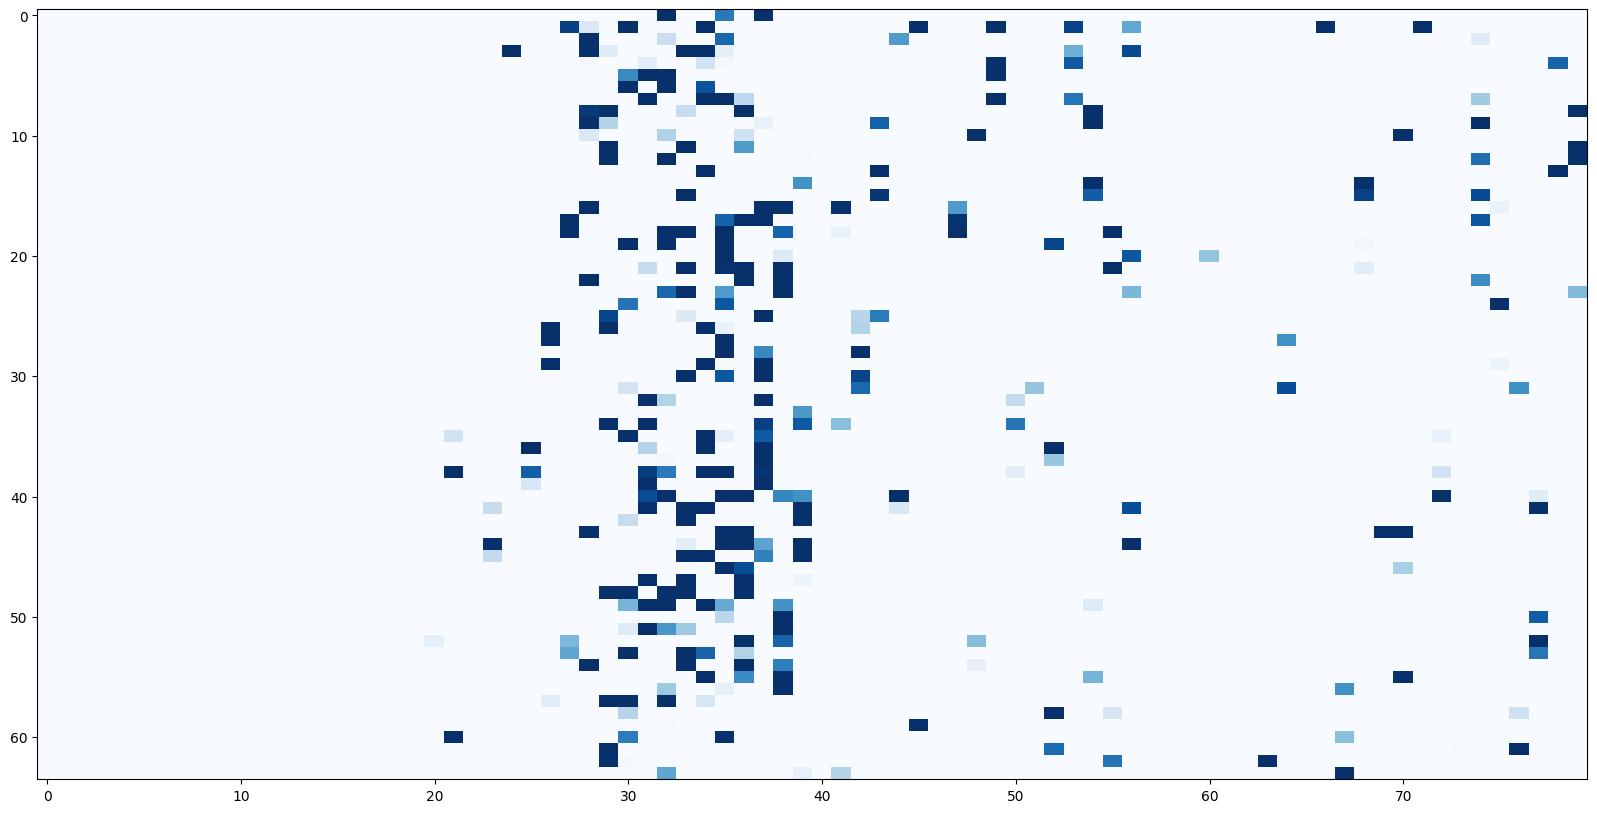

In [321]:
plt.figure(figsize=(20, 10))

optimal_head_mask = torch.tensor(optimization_results["optimal_mask"]).to(torch.float32)

plt.imshow(
    optimal_head_mask.T.numpy(),
    cmap="Blues",
    aspect="auto",
    vmin=0,
    vmax=1,
)

heads_selected = torch.nonzero(optimal_head_mask > 0.5, as_tuple=False).tolist()
heads_selected = [
    (layer_idx, head_idx) for layer_idx, head_idx in heads_selected if layer_idx < 50
]
len(heads_selected)

HEADS = heads_selected

## Utils

In [11]:
HEADS = [
    (33, 45),
    (33, 18),
    (34, 1),
    (34, 6),
    (34, 7),
    (35, 19),
    (39, 40),
    (42, 30),
    (47, 18),
    (52, 58),
]

In [21]:
import copy
import random
from src.selection.utils import KeyedSet, get_first_token_id, verify_correct_option
from src.selection.data import SelectionSample
from src.tokens import prepare_input
from src.selection.data import SelectOddOneOutTask

@torch.inference_mode()
def get_counterfactual_samples_odd_one_out(
    task: SelectOddOneOutTask,
    obj_category: str | None = None,
    distractor_category: str | None = None,
    prompt_template_idx=3,
    option_style="single_line",
    filter_by_lm_prediction: bool = True,
    n_distractors: int = 5,
    counterfact_obj_idx: int | None = None,
):
    obj_category = obj_category or random.choice(task.categories)
    distractor_category = distractor_category or random.choice(
        list(set(task.categories) - {obj_category})
    )
    assert obj_category != distractor_category, f"{obj_category=} {distractor_category=}"

    logger.info(
        f"obj_category={obj_category}, distractor_category={distractor_category}, prompt_template_idx={prompt_template_idx}, option_style={option_style}, n_distractors={n_distractors}"
    )

    patch_sample = task.get_random_sample(
        mt=mt,
        option_style=option_style,
        prompt_template_idx=prompt_template_idx,
        obj_category=obj_category,
        distractor_category=distractor_category,
        filter_by_lm_prediction=False,
        n_distractors=n_distractors,
        obj_idx = random.choice(list(set(list(range(n_distractors + 1))) - {0, 1}))
    )
    logger.info(f"patch_sample={str(patch_sample)}")

    #! criterion = not distractor_category
    # Options (2): 
    # 1. distractor_category (selected)
    # 2. category not in [obj_category, distractor_category] 
    not_dist_category_sample = task.get_random_sample(
        mt=mt,
        option_style=option_style,
        prompt_template_idx=prompt_template_idx,
        obj_category=distractor_category,
        distractor_category=random.choice(
            list(set(task.categories) - {obj_category, distractor_category})
        ),
        filter_by_lm_prediction=False,
        exclude_objs=patch_sample.options,
        n_distractors=1,
        obj_idx=counterfact_obj_idx
    )
    logger.info(f"not_dist_category_sample={str(not_dist_category_sample)}")
    track_idx = 1 ^ not_dist_category_sample.obj_idx
    not_dist_category_sample.metadata = {
        "track_type_obj": not_dist_category_sample.options[track_idx],
        "track_type_obj_idx": track_idx,
        "track_type_obj_token_id": get_first_token_id(
            not_dist_category_sample.options[track_idx], mt.tokenizer, prefix=" "
        ),
    }

    #! criterion = is obj_category
    # Options (2):
    # 1. obj_category
    # 2. category not in [obj_category, distractor_category] (selected)
    is_obj_category_sample = task.get_random_sample(
        mt=mt,
        option_style=option_style,
        prompt_template_idx=prompt_template_idx,
        distractor_category=obj_category,
        obj_category=random.choice(
            list(set(task.categories) - {obj_category, distractor_category})
        ),
        filter_by_lm_prediction=False,
        exclude_objs=patch_sample.options,
        n_distractors=1,
        obj_idx=counterfact_obj_idx
    )
    logger.info(f"is_obj_category_sample={str(is_obj_category_sample)}")
    track_idx = 1 ^ is_obj_category_sample.obj_idx
    is_obj_category_sample.metadata = {
        "track_type_obj_idx": track_idx,
        "track_type_obj": is_obj_category_sample.options[track_idx],
        "track_type_obj_category": obj_category,
        "track_type_obj_token_id": get_first_token_id(
            is_obj_category_sample.options[track_idx], mt.tokenizer, prefix=" "
        ),
    }

    if filter_by_lm_prediction:
        test_samples = [patch_sample, not_dist_category_sample, is_obj_category_sample]

        for sample in test_samples:
            tokenized = prepare_input(tokenizer=mt, prompts=sample.prompt())
            is_correct, predictions, track_options = verify_correct_option(
                mt=mt, target=sample.obj, options=sample.options, input=tokenized
            )
            sample.metadata["tokenized"] = tokenized.data
            logger.info(sample.prompt())
            logger.info(
                f"{sample.subj} | {sample.category} -> {sample.obj} | pred={[str(p) for p in predictions]}"
            )
            if not is_correct:
                logger.error(
                    f'Prediction mismatch: {track_options[list(track_options.keys())[0]]}["{mt.tokenizer.decode(predictions[0].token_id)}"] != {sample.ans_token_id}["{mt.tokenizer.decode(sample.ans_token_id)}"]'
                )
                return get_counterfactual_samples_odd_one_out(
                    task=task,
                    obj_category=obj_category,
                    distractor_category=distractor_category,
                    prompt_template_idx=prompt_template_idx,
                    option_style=option_style,
                    filter_by_lm_prediction=filter_by_lm_prediction,
                    n_distractors=n_distractors,
                )
            sample.prediction = predictions

    return {
        "patch_sample": patch_sample,
        "not_dist_category_sample": not_dist_category_sample,
        "is_obj_category_sample": is_obj_category_sample
    }

## Experiments

In [22]:
from src.selection.data import SelectOddOneOutTask

select_odd_one = SelectOddOneOutTask.load(
    path=os.path.join(
        env_utils.DEFAULT_DATA_DIR, 
        "selection", 
        # "profession.json"
        # "nationality.json"
        "objects.json"
    )
)

print(select_odd_one)

SelectOddOneOutTask: (different objects)
Categories: fruit(15), vehicle(15), furniture(15), animal(15), music instrument(15), clothing(15), electronics(15), sport equipment(15), kitchen appliance(15), vegetable(14), building(15), office supply(15), bathroom item(15), flower(15), tree(15), jewelry(15)



In [23]:
#############################################
distractor_category="fruit"
obj_category="electronics"
option_style="single_line"
# option_style="numbered"
prompt_template_idx=3
N_DISTRACTORS = 5
counterfact_obj_idx = 1  # 0 or 1, if None, will be randomly selected
#############################################

In [27]:
exp_samples = get_counterfactual_samples_odd_one_out(
    task=select_odd_one,
    # obj_category=obj_category,
    # distractor_category=distractor_category,
    prompt_template_idx=prompt_template_idx,
    option_style=option_style,
    filter_by_lm_prediction=True,
    n_distractors=5
)

patch_sample = exp_samples["patch_sample"]
not_dist_category_sample = exp_samples["not_dist_category_sample"]
is_obj_category_sample = exp_samples["is_obj_category_sample"]

2025-08-14 19:11:42 __main__ INFO     obj_category=electronics, distractor_category=furniture, prompt_template_idx=3, option_style=single_line, n_distractors=5


2025-08-14 19:11:42 __main__ INFO     patch_sample=Bed -> Phone (3): ['Bookshelf', 'Dresser', 'Chair', 'Phone', 'Coffee table', 'Recliner']
2025-08-14 19:11:43 __main__ INFO     not_dist_category_sample=Coffee maker -> Bench (0): ['Bench', 'Blender']
2025-08-14 19:11:43 __main__ INFO     is_obj_category_sample=Router -> Tomato (0): ['Tomato', 'Monitor']
2025-08-14 19:11:43 __main__ INFO     Options: Bookshelf, Dresser, Chair, Phone, Coffee table, Recliner.
Which among these objects mentioned above is not a furniture?
Answer:
2025-08-14 19:11:43 __main__ INFO     Bed | furniture -> Phone | pred=['" Phone"[14642] (p=0.844, logit=21.750)', '" The"[578] (p=0.054, logit=19.000)', '" A"[362] (p=0.026, logit=18.250)', '" Among"[22395] (p=0.022, logit=18.125)', '" ""[330] (p=0.006, logit=16.875)']
2025-08-14 19:11:43 __main__ INFO     Options: Bench, Blender.
Which among these objects mentioned above is not a kitchen appliance?
Answer:
2025-08-14 19:11:43 __main__ INFO     Coffee maker | kitch

In [28]:
print(patch_sample)
print(f'"{patch_sample.prompt()}"', ">>", patch_sample.obj)

Bed -> Phone (3): ['Bookshelf', 'Dresser', 'Chair', 'Phone', 'Coffee table', 'Recliner']
"Options: Bookshelf, Dresser, Chair, Phone, Coffee table, Recliner.
Which among these objects mentioned above is not a furniture?
Answer:" >> Phone


In [29]:
patch_attn_info = verify_head_patterns(
    prompt = patch_sample.prompt(),
    options = patch_sample.options,
    pivot = patch_sample.subj,
    mt = mt,
    heads = HEADS
)

not_dist_category_attn_info = verify_head_patterns(
    prompt = not_dist_category_sample.prompt(),
    options = not_dist_category_sample.options,
    pivot = not_dist_category_sample.subj,
    mt = mt,
    heads = HEADS
)

is_obj_category_attn_info = verify_head_patterns(
    prompt = is_obj_category_sample.prompt(),
    options = is_obj_category_sample.options,
    pivot = is_obj_category_sample.subj,
    mt = mt,
    heads = HEADS
)

0 patches to ablate possible answer information from options
2025-08-14 19:11:44 src.selection.functional DEBUG    Predictions: ['" Phone"[14642] (p=0.844, logit=21.750)', '" The"[578] (p=0.054, logit=19.000)', '" A"[362] (p=0.026, logit=18.250)', '" Among"[22395] (p=0.022, logit=18.125)', '" ""[330] (p=0.006, logit=16.875)']
2025-08-14 19:11:44 src.selection.functional INFO     Combined attention matrix for all heads


0 patches to ablate possible answer information from options
2025-08-14 19:11:44 src.selection.functional DEBUG    Predictions: ['" Bench"[36358] (p=0.887, logit=21.500)', '" A"[362] (p=0.044, logit=18.500)', '" The"[578] (p=0.024, logit=17.875)', '" ("[320] (p=0.014, logit=17.375)', '" B"[426] (p=0.004, logit=16.000)']
2025-08-14 19:11:44 src.selection.functional INFO     Combined attention matrix for all heads


0 patches to ablate possible answer information from options
2025-08-14 19:11:44 src.selection.functional DEBUG    Predictions: ['" Tomato"[94091] (p=0.922, logit=21.375)', '" tomato"[42120] (p=0.017, logit=17.375)', '" The"[578] (p=0.010, logit=16.875)', '" ("[320] (p=0.010, logit=16.875)', '" Option"[7104] (p=0.005, logit=16.125)']
2025-08-14 19:11:44 src.selection.functional INFO     Combined attention matrix for all heads


In [30]:
patch_tokenized = prepare_input(prompts=patch_sample.prompt(), tokenizer=mt)
[mt.tokenizer.decode(patch_tokenized.input_ids[0][t]) for t in range(-3, 0)]

['?\n', 'Answer', ':']

In [31]:
not_dist_category_sample.metadata

{'track_type_obj': 'Blender',
 'track_type_obj_idx': 1,
 'track_type_obj_token_id': 88668,
 'tokenized': {'input_ids': tensor([[128000,   3883,     25,  36358,     11,  88668,    627,  23956,   4315,
             1521,   6302,   9932,   3485,    374,    539,    264,   9979,  56454,
             5380,  16533,     25]], device='cuda:0'),
  'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
         device='cuda:0')}}

In [32]:
not_dist_category_patch = validate_q_proj_ie_on_sample_pair(
    mt=mt,
    clean_sample=not_dist_category_sample,
    patch_sample=patch_sample,
    heads=HEADS,
    query_indices=[-3, -2, -1],
    verify_head_behavior_on=-1,
)

print("-" * 100)

clean_obj_tok = get_first_token_id(not_dist_category_sample.obj, tokenizer=mt.tokenizer, prefix=" ")
target_obj_tok = not_dist_category_sample.metadata["track_type_obj_token_id"]

before_clean = not_dist_category_patch["clean_track"][clean_obj_tok][1].logit
after_clean = not_dist_category_patch["int_track"][clean_obj_tok][1].logit
delta_clean = after_clean - before_clean
print(f"\"{mt.tokenizer.decode(clean_obj_tok)}\" |>> {before_clean=}, {after_clean=} | {delta_clean=}")

before_target = not_dist_category_patch["clean_track"][target_obj_tok][1].logit
after_target = not_dist_category_patch["int_track"][target_obj_tok][1].logit
delta_target = after_target - before_target
print(f"\"{mt.tokenizer.decode(target_obj_tok)}\" |>> {before_target=}, {after_target=} | {delta_target=}")

2025-08-14 19:12:20 src.selection.functional INFO     Verifying head behavior...
2025-08-14 19:12:20 src.selection.functional INFO     Clean Sample >> Ans: Bench


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


0 patches to ablate possible answer information from options
2025-08-14 19:12:23 src.selection.functional DEBUG    Generated full answer: " Bench
Explanation: A bench is a piece of furniture, typically found in a garden, park, or other outdoor setting, used for sitting. It"
2025-08-14 19:12:23 src.selection.functional DEBUG    Predictions: ['" Bench"[36358] (p=0.887, logit=21.500)', '" A"[362] (p=0.044, logit=18.500)', '" The"[578] (p=0.024, logit=17.875)', '" ("[320] (p=0.014, logit=17.375)', '" B"[426] (p=0.004, logit=16.000)']
2025-08-14 19:12:23 src.selection.functional INFO     Combined attention matrix for all heads


2025-08-14 19:12:24 src.selection.functional INFO     Patch Sample >> Ans: Phone


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


0 patches to ablate possible answer information from options
2025-08-14 19:12:27 src.selection.functional DEBUG    Generated full answer: " Phone
Explanation: Phone is an electronic device and not a furniture. All the other options are types of furniture. 
This question requires the ability to"
2025-08-14 19:12:27 src.selection.functional DEBUG    Predictions: ['" Phone"[14642] (p=0.844, logit=21.750)', '" The"[578] (p=0.054, logit=19.000)', '" A"[362] (p=0.026, logit=18.250)', '" Among"[22395] (p=0.022, logit=18.125)', '" ""[330] (p=0.006, logit=16.875)']
2025-08-14 19:12:27 src.selection.functional INFO     Combined attention matrix for all heads


2025-08-14 19:12:27 src.selection.functional INFO     Caching the query states for the 10 heads
2025-08-14 19:12:28 src.selection.functional INFO     patch_prediction=['" Phone"[14642] (p=0.844, logit=21.750)', '" The"[578] (p=0.054, logit=19.000)', '" A"[362] (p=0.026, logit=18.250)', '" Among"[22395] (p=0.022, logit=18.125)', '" ""[330] (p=0.006, logit=16.875)']
2025-08-14 19:12:28 src.selection.functional INFO     clean run
2025-08-14 19:12:28 src.selection.functional INFO     clean_prediction=['" Bench"[36358] (p=0.887, logit=21.500)', '" A"[362] (p=0.044, logit=18.500)', '" The"[578] (p=0.024, logit=17.875)', '" ("[320] (p=0.014, logit=17.375)', '" B"[426] (p=0.004, logit=16.000)']
2025-08-14 19:12:28 src.selection.functional INFO     clean_track=OrderedDict([(36358, (1, PredictedToken(token=' Bench', prob=0.88671875, logit=21.5, token_id=36358, metadata=None))), (88668, (13, PredictedToken(token=' Blender', prob=0.00091552734375, logit=14.625, token_id=88668, metadata=None))), (1

2025-08-14 19:12:28 src.selection.functional INFO     int_prediction=['" Bench"[36358] (p=0.836, logit=21.000)', '" Blender"[88668] (p=0.088, logit=18.750)', '" The"[578] (p=0.017, logit=17.125)', '" ("[320] (p=0.015, logit=17.000)', '" A"[362] (p=0.013, logit=16.875)']
2025-08-14 19:12:28 src.selection.functional INFO     int_track=OrderedDict([(36358, (1, PredictedToken(token=' Bench', prob=0.8359375, logit=21.0, token_id=36358, metadata=None))), (88668, (2, PredictedToken(token=' Blender', prob=0.087890625, logit=18.75, token_id=88668, metadata=None))), (14642, (420, PredictedToken(token=' Phone', prob=3.3080577850341797e-06, logit=8.5625, token_id=14642, metadata=None)))])
----------------------------------------------------------------------------------------------------
" Bench" |>> before_clean=21.5, after_clean=21.0 | delta_clean=-0.5
" Blender" |>> before_target=14.625, after_target=18.75 | delta_target=4.125


In [33]:
is_patch_cat_selection_patch = validate_q_proj_ie_on_sample_pair(
    mt=mt,
    clean_sample=is_obj_category_sample,
    patch_sample=patch_sample,
    heads=HEADS,
    query_indices=[-3, -2, -1],
    verify_head_behavior_on=-1,
)

print("-" * 100)
clean_obj_tok = get_first_token_id(is_obj_category_sample.obj, tokenizer=mt.tokenizer, prefix=" ")
target_obj_tok = is_obj_category_sample.metadata["track_type_obj_token_id"]
before_clean = is_patch_cat_selection_patch["clean_track"][clean_obj_tok][1].logit
after_clean = is_patch_cat_selection_patch["int_track"][clean_obj_tok][1].logit
delta_clean = after_clean - before_clean
print(f"\"{mt.tokenizer.decode(clean_obj_tok)}\" |>> {before_clean=}, {after_clean=} | {delta_clean=}")

before_target = is_patch_cat_selection_patch["clean_track"][target_obj_tok][1].logit
after_target = is_patch_cat_selection_patch["int_track"][target_obj_tok][1].logit
delta_target = after_target - before_target
print(f"\"{mt.tokenizer.decode(target_obj_tok)}\" |>> {before_target=}, {after_target=} | {delta_target=}")

2025-08-14 19:12:48 src.selection.functional INFO     Verifying head behavior...
2025-08-14 19:12:48 src.selection.functional INFO     Clean Sample >> Ans: Tomato


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


0 patches to ablate possible answer information from options
2025-08-14 19:12:52 src.selection.functional DEBUG    Generated full answer: " Tomato
Explanation: Tomato is a vegetable and not an electronics. Monitor is an electronics. So, the correct answer is Tomato. Tomato is not an"
2025-08-14 19:12:52 src.selection.functional DEBUG    Predictions: ['" Tomato"[94091] (p=0.922, logit=21.375)', '" tomato"[42120] (p=0.017, logit=17.375)', '" The"[578] (p=0.010, logit=16.875)', '" ("[320] (p=0.010, logit=16.875)', '" Option"[7104] (p=0.005, logit=16.125)']
2025-08-14 19:12:52 src.selection.functional INFO     Combined attention matrix for all heads


2025-08-14 19:12:52 src.selection.functional INFO     Patch Sample >> Ans: Phone


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


0 patches to ablate possible answer information from options
2025-08-14 19:12:56 src.selection.functional DEBUG    Generated full answer: " Phone
Explanation: Phone is an electronic device and not a furniture. All the other options are types of furniture. 
This question requires the ability to"
2025-08-14 19:12:56 src.selection.functional DEBUG    Predictions: ['" Phone"[14642] (p=0.844, logit=21.750)', '" The"[578] (p=0.054, logit=19.000)', '" A"[362] (p=0.026, logit=18.250)', '" Among"[22395] (p=0.022, logit=18.125)', '" ""[330] (p=0.006, logit=16.875)']
2025-08-14 19:12:56 src.selection.functional INFO     Combined attention matrix for all heads


2025-08-14 19:12:56 src.selection.functional INFO     Caching the query states for the 10 heads
2025-08-14 19:12:56 src.selection.functional INFO     patch_prediction=['" Phone"[14642] (p=0.844, logit=21.750)', '" The"[578] (p=0.054, logit=19.000)', '" A"[362] (p=0.026, logit=18.250)', '" Among"[22395] (p=0.022, logit=18.125)', '" ""[330] (p=0.006, logit=16.875)']
2025-08-14 19:12:56 src.selection.functional INFO     clean run
2025-08-14 19:12:56 src.selection.functional INFO     clean_prediction=['" Tomato"[94091] (p=0.922, logit=21.375)', '" tomato"[42120] (p=0.017, logit=17.375)', '" The"[578] (p=0.010, logit=16.875)', '" ("[320] (p=0.010, logit=16.875)', '" Option"[7104] (p=0.005, logit=16.125)']
2025-08-14 19:12:56 src.selection.functional INFO     clean_track=OrderedDict([(94091, (1, PredictedToken(token=' Tomato', prob=0.921875, logit=21.375, token_id=94091, metadata=None))), (24423, (11, PredictedToken(token=' Monitor', prob=0.001678466796875, logit=15.0625, token_id=24423, met

2025-08-14 19:12:57 src.selection.functional INFO     int_prediction=['" Tomato"[94091] (p=0.941, logit=21.750)', '" tomato"[42120] (p=0.015, logit=17.625)', '" ("[320] (p=0.008, logit=17.000)', '" The"[578] (p=0.006, logit=16.625)', '" Option"[7104] (p=0.003, logit=16.125)']
2025-08-14 19:12:57 src.selection.functional INFO     int_track=OrderedDict([(94091, (1, PredictedToken(token=' Tomato', prob=0.94140625, logit=21.75, token_id=94091, metadata=None))), (24423, (6, PredictedToken(token=' Monitor', prob=0.0028076171875, logit=15.9375, token_id=24423, metadata=None))), (14642, (588, PredictedToken(token=' Phone', prob=9.760260581970215e-07, logit=7.96875, token_id=14642, metadata=None)))])
----------------------------------------------------------------------------------------------------
" Tomato" |>> before_clean=21.375, after_clean=21.75 | delta_clean=0.375
" Monitor" |>> before_target=15.0625, after_target=15.9375 | delta_target=0.875


In [34]:
count_sample = SelectionSample(
    obj = "Banana",
    answer = "3",
    obj_idx = 3,
    # prompt_template="""<_options_>\nCount the number of fruits in the list\nAnswer:""",
    prompt_template="""Count the number of fruits in the following list:\n<_options_>\nAnswer:""",
    # prompt_template="""<_options_>\nAnswer:""",
    options=["Bus", "Apple", "Microphone", "Banana", "Orange", "Cow", "Table"],
    # default_option_style="numbered",
    # default_option_style="bullet",
)

print(count_sample.prompt())

validate_q_proj_ie_on_sample_pair(
    mt=mt,
    clean_sample=count_sample,
    patch_sample=patch_sample,
    heads=HEADS,
    query_indices=[-2, -1],
    verify_head_behavior_on=-1,
)

Count the number of fruits in the following list:
Options: Bus, Apple, Microphone, Banana, Orange, Cow, Table.
Answer:
2025-08-14 19:13:16 src.selection.functional INFO     Verifying head behavior...
2025-08-14 19:13:16 src.selection.functional INFO     Clean Sample >> Ans: Banana


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


0 patches to ablate possible answer information from options
2025-08-14 19:13:19 src.selection.functional DEBUG    Generated full answer: " There are 3 fruits in the list: Apple, Banana, and Orange.
This question requires the ability to identify and count the number of fruits in"
2025-08-14 19:13:19 src.selection.functional DEBUG    Predictions: ['" There"[2684] (p=0.559, logit=21.500)', '" "[220] (p=0.264, logit=20.750)', '" The"[578] (p=0.085, logit=19.625)', '" Three"[14853] (p=0.046, logit=19.000)', '" We"[1226] (p=0.006, logit=17.000)']
2025-08-14 19:13:19 src.selection.functional INFO     Combined attention matrix for all heads


2025-08-14 19:13:19 src.selection.functional INFO     Patch Sample >> Ans: Phone


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


0 patches to ablate possible answer information from options
2025-08-14 19:13:23 src.selection.functional DEBUG    Generated full answer: " Phone
Explanation: Phone is an electronic device and not a furniture. All the other options are types of furniture. 
This question requires the ability to"
2025-08-14 19:13:23 src.selection.functional DEBUG    Predictions: ['" Phone"[14642] (p=0.844, logit=21.750)', '" The"[578] (p=0.054, logit=19.000)', '" A"[362] (p=0.026, logit=18.250)', '" Among"[22395] (p=0.022, logit=18.125)', '" ""[330] (p=0.006, logit=16.875)']
2025-08-14 19:13:23 src.selection.functional INFO     Combined attention matrix for all heads


2025-08-14 19:13:23 src.selection.functional INFO     Caching the query states for the 10 heads
2025-08-14 19:13:23 src.selection.functional INFO     patch_prediction=['" Phone"[14642] (p=0.844, logit=21.750)', '" The"[578] (p=0.054, logit=19.000)', '" A"[362] (p=0.026, logit=18.250)', '" Among"[22395] (p=0.022, logit=18.125)', '" ""[330] (p=0.006, logit=16.875)']
2025-08-14 19:13:23 src.selection.functional INFO     clean run
2025-08-14 19:13:23 src.selection.functional INFO     clean_prediction=['" There"[2684] (p=0.559, logit=21.500)', '" "[220] (p=0.264, logit=20.750)', '" The"[578] (p=0.085, logit=19.625)', '" Three"[14853] (p=0.046, logit=19.000)', '" We"[1226] (p=0.006, logit=17.000)']
2025-08-14 19:13:23 src.selection.functional INFO     clean_track=OrderedDict([(8325, (8, PredictedToken(token=' Apple', prob=0.0025787353515625, logit=16.125, token_id=8325, metadata=None))), (19111, (34, PredictedToken(token=' Bus', prob=0.0003490447998046875, logit=14.125, token_id=19111, metad

2025-08-14 19:13:24 src.selection.functional INFO     int_prediction=['" There"[2684] (p=0.582, logit=21.500)', '" "[220] (p=0.243, logit=20.625)', '" The"[578] (p=0.079, logit=19.500)', '" Three"[14853] (p=0.042, logit=18.875)', '" We"[1226] (p=0.006, logit=17.000)']
2025-08-14 19:13:24 src.selection.functional INFO     int_track=OrderedDict([(19111, (10, PredictedToken(token=' Bus', prob=0.00185394287109375, logit=15.75, token_id=19111, metadata=None))), (8325, (13, PredictedToken(token=' Apple', prob=0.0013580322265625, logit=15.4375, token_id=8325, metadata=None))), (18654, (38, PredictedToken(token=' Micro', prob=0.0002841949462890625, logit=13.875, token_id=18654, metadata=None))), (76924, (133, PredictedToken(token=' Banana', prob=1.9431114196777344e-05, logit=11.1875, token_id=76924, metadata=None))), (22725, (146, PredictedToken(token=' Orange', prob=1.5079975128173828e-05, logit=10.9375, token_id=22725, metadata=None))), (6771, (741, PredictedToken(token=' Table', prob=7.7486

{'clean_sample': SelectionSample(obj='Banana', answer='3', obj_idx=3, prompt_template='Count the number of fruits in the following list:\n<_options_>\nAnswer:', options=['Bus', 'Apple', 'Microphone', 'Banana', 'Orange', 'Cow', 'Table'], subj=None, category=None, prediction=None, ans_token_id=None, metadata={}, default_option_style='single_line'),
 'patch_sample': SelectionSample(obj='Phone', answer='Phone', obj_idx=3, prompt_template='<_options_>\nWhich among these objects mentioned above is not a <_category_>?\nAnswer:', options=['Bookshelf', 'Dresser', 'Chair', 'Phone', 'Coffee table', 'Recliner'], subj='Bed', category='furniture', prediction=[PredictedToken(token=' Phone', prob=0.84375, logit=21.75, token_id=14642, metadata=None), PredictedToken(token=' The', prob=0.053955078125, logit=19.0, token_id=578, metadata=None), PredictedToken(token=' A', prob=0.0255126953125, logit=18.25, token_id=362, metadata=None), PredictedToken(token=' Among', prob=0.0224609375, logit=18.125, token_id

### Search for heads with the most patching effect

In [145]:
from itertools import product
from src.functional import patch_with_baukit, interpret_logits

all_heads = list(product(range(30, 50), range(mt.config.num_attention_heads)))
query_indices = [-3, -2, -1]  # last 3 tokens
query_locations = [
    (layer_idx, head_idx, query_idx)
    for layer_idx, head_idx in all_heads
    for query_idx in query_indices
]

patch_tokenized = prepare_input(prompts=patch_sample.prompt(), tokenizer=mt)
cached_q_states, patch_output = cache_q_projections(
    mt=mt,
    input=patch_tokenized,
    query_locations=query_locations,
    return_output=True,
)

patch_logits = patch_output.logits[:, -1, :].squeeze()
interpret_logits(
    tokenizer=mt,
    logits=patch_logits,
)

[PredictedToken(token=' Router', prob=0.81640625, logit=20.25, token_id=10777, metadata=None),
 PredictedToken(token=' The', prob=0.05908203125, logit=17.625, token_id=578, metadata=None),
 PredictedToken(token=' A', prob=0.021728515625, logit=16.625, token_id=362, metadata=None),
 PredictedToken(token=' Among', prob=0.0169677734375, logit=16.375, token_id=22395, metadata=None),
 PredictedToken(token=' It', prob=0.009033203125, logit=15.75, token_id=1102, metadata=None)]

In [146]:
clean_sample_type = {
    "not_dist_category": not_dist_category_sample,
    "is_obj_category": is_obj_category_sample,
}

base_scores = {}

for sample_type, clean_sample in clean_sample_type.items():
    clean_tokenized = prepare_input(prompts=clean_sample.prompt(), tokenizer=mt)
    clean_sample.metadata["tokenized"] = clean_tokenized.data

    clean_out = patch_with_baukit(
        mt=mt,
        inputs=clean_tokenized,
        patches=[],
    )
    base_logits = clean_out.logits[:, -1, :].squeeze()
    base_predictions, base_track = interpret_logits(
        tokenizer=mt,
        logits=base_logits,
        interested_tokens=[
            get_first_token_id(clean_sample.obj, tokenizer=mt.tokenizer, prefix=" "),
            clean_sample.metadata["track_obj_token_id"],
        ],
    )
    print(base_track[clean_sample.metadata["track_obj_token_id"]])
    base_scores[sample_type] = base_track[clean_sample.metadata["track_obj_token_id"]]

(4, PredictedToken(token=' R', prob=0.0115966796875, logit=16.125, token_id=432, metadata=None))
(3, PredictedToken(token=' Mouse', prob=0.05615234375, logit=17.375, token_id=18191, metadata=None))


In [147]:
base_scores

{'not_dist_category': (4,
  PredictedToken(token=' R', prob=0.0115966796875, logit=16.125, token_id=432, metadata=None)),
 'is_obj_category': (3,
  PredictedToken(token=' Mouse', prob=0.05615234375, logit=17.375, token_id=18191, metadata=None))}

In [148]:
q_proj_patches = []
for (layer_idx, head_idx, query_idx), q_proj in cached_q_states.items():
    q_proj_patches.append(
        PatchSpec(
            location=(
                mt.attn_module_name_format.format(layer_idx) + ".q_proj",
                head_idx,
                query_idx,
            ),
            patch=q_proj,
        )
    )

int_scores = {}
for sample_type, clean_sample in clean_sample_type.items():
    clean_tokenized = TokenizerOutput(data=clean_sample.metadata["tokenized"])

    int_out = patch_with_baukit(
        mt=mt,
        inputs=clean_tokenized,
        patches=q_proj_patches,
    )
    int_logits = int_out.logits[:, -1, :].squeeze()
    int_predictions, int_track = interpret_logits(
        tokenizer=mt,
        logits=int_logits,
        interested_tokens=[
            get_first_token_id(clean_sample.obj, tokenizer=mt.tokenizer, prefix=" "),
            clean_sample.metadata["track_obj_token_id"],
        ],
    )
    print(int_track[clean_sample.metadata["track_obj_token_id"]])
    int_scores[sample_type] = int_track[clean_sample.metadata["track_obj_token_id"]]

(2, PredictedToken(token=' R', prob=0.24609375, logit=17.25, token_id=432, metadata=None))
(2, PredictedToken(token=' Mouse', prob=0.314453125, logit=19.125, token_id=18191, metadata=None))


In [149]:
individual_patching_effects = {
    "not_dist_category": {},
    "is_obj_category": {},
}
print(query_indices)
for layer_idx, head_idx in tqdm(all_heads, desc="Iterating over heads"):
    q_proj_patches = [
        PatchSpec(
            location=(
                mt.attn_module_name_format.format(layer_idx) + ".q_proj",
                head_idx,
                query_idx,
            ),
            patch= cached_q_states[(layer_idx, head_idx, query_idx)],
        ) for query_idx in query_indices
    ]
    for sample_type, clean_sample in clean_sample_type.items():
        clean_tokenized = TokenizerOutput(data=clean_sample.metadata["tokenized"])

        # Patch the q_proj for the current head
        out = patch_with_baukit(
            mt=mt,
            inputs=clean_tokenized,
            patches=q_proj_patches,
        )
        logits = out.logits[:, -1, :].squeeze()
        target_tok = clean_sample.metadata["track_obj_token_id"]
        predictions, track = interpret_logits(
            tokenizer=mt,
            logits=logits,
            interested_tokens=[target_tok],
        )
        individual_patching_effects[sample_type][
            (layer_idx, head_idx)
        ] = track

[-3, -2, -1]


Iterating over heads:   0%|          | 0/1280 [00:00<?, ?it/s]

In [151]:
not_dist_category_sample.metadata

{'track_idx': 0,
 'track_obj': 'Racket',
 'track_obj_category': 'fruit',
 'track_obj_token_id': 432,
 'tokenized': {'input_ids': tensor([[128000,   3883,     25,    432,   5827,     11,  45805,    627,  23956,
             4315,   1521,   6302,   9932,   3485,    374,    539,    264,  10775,
             7241,   5380,  16533,     25]], device='cuda:0'),
  'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
         device='cuda:0')},
 'pred_track': OrderedDict([(45805,
               (1,
                PredictedToken(token=' Cherry', prob=0.91796875, logit=20.5, token_id=45805, metadata=None))),
              (432,
               (4,
                PredictedToken(token=' R', prob=0.0115966796875, logit=16.125, token_id=432, metadata=None)))])}

In [159]:
from scripts.patching_within_task import SelectionQprojPatchResult

not_dist_category_headwise_ie = SelectionQprojPatchResult(
    patch_sample=patch_sample,
    clean_sample=not_dist_category_sample,
    interested_tokens=[not_dist_category_sample.metadata["track_obj_token_id"]],
    base_results=base_scores["not_dist_category"],
    headwise_patching_effects=individual_patching_effects["not_dist_category"],
)

is_obj_category_headwise_ie = SelectionQprojPatchResult(
    patch_sample=patch_sample,
    clean_sample=is_obj_category_sample,
    interested_tokens=[is_obj_category_sample.metadata["track_obj_token_id"]],
    base_results=base_scores["is_obj_category"],
    headwise_patching_effects=individual_patching_effects["is_obj_category"],
)

In [165]:
patching_results = not_dist_category_headwise_ie
patching_results = is_obj_category_headwise_ie

headwise_scores = [
    (
        layer_idx,
        head_idx,
        patching_results.head_effect(layer_idx, head_idx)
    )
    for layer_idx, head_idx in patching_results.headwise_patching_effects.keys()
]

headwise_scores = sorted(headwise_scores, key=lambda x: x[2], reverse=True)
patching_heads = []
for layer_idx, head_idx, score in headwise_scores[:15]:
    print(f"Layer {layer_idx}, Head {head_idx}: {score:.4f}")
    patching_heads.append((layer_idx, head_idx))

Layer 33, Head 44: 0.6250
Layer 33, Head 45: 0.3750
Layer 31, Head 36: 0.2500
Layer 32, Head 23: 0.2500
Layer 30, Head 11: 0.1250
Layer 30, Head 39: 0.1250
Layer 30, Head 48: 0.1250
Layer 30, Head 54: 0.1250
Layer 30, Head 55: 0.1250
Layer 30, Head 60: 0.1250
Layer 31, Head 24: 0.1250
Layer 31, Head 38: 0.1250
Layer 31, Head 45: 0.1250
Layer 31, Head 47: 0.1250
Layer 31, Head 50: 0.1250


## Optimization to select heads to patch

In [35]:
# print(clean_sample.prompt(), ">>", clean_sample.obj)
# print(patch_sample.prompt(), ">>", patch_sample.obj)

# train_set = [(clean_sample, patch_sample)]


In [36]:
from src.functional import free_gpu_cache
free_gpu_cache()

#################################################################################
train_limit = 512
prompt_template_idx = 1
N_DISTRACTORS = 5
OPTION_STYLE = "single_line"
#################################################################################

train_set = []
while len(train_set) < train_limit:
    samples = get_counterfactual_samples_odd_one_out(
        task=select_odd_one,
        filter_by_lm_prediction=True,
        prompt_template_idx=3,
        option_style="single_line",
        n_distractors=5
    )
    train_set.append(samples)

2025-08-14 19:13:35 __main__ INFO     obj_category=building, distractor_category=bathroom item, prompt_template_idx=3, option_style=single_line, n_distractors=5
2025-08-14 19:13:35 __main__ INFO     patch_sample=Sink -> Factory (3): ['Shower', 'Mirror', 'Toothbrush', 'Factory', 'Razor', 'Hairdryer']
2025-08-14 19:13:35 __main__ INFO     not_dist_category_sample=Router -> Shampoo (0): ['Shampoo', 'Mouse']
2025-08-14 19:13:35 __main__ INFO     is_obj_category_sample=Mall -> Tiger (1): ['Theater', 'Tiger']
2025-08-14 19:13:35 __main__ INFO     Options: Shower, Mirror, Toothbrush, Factory, Razor, Hairdryer.
Which among these objects mentioned above is not a bathroom item?
Answer:
2025-08-14 19:13:35 __main__ INFO     Sink | bathroom item -> Factory | pred=['" Factory"[17367] (p=0.906, logit=21.500)', '" The"[578] (p=0.027, logit=18.000)', '" A"[362] (p=0.027, logit=18.000)', '" Among"[22395] (p=0.004, logit=16.125)', '" Tooth"[83499] (p=0.003, logit=15.938)']
2025-08-14 19:13:35 __main__ I

In [37]:
mt._model.zero_grad()
free_gpu_cache()

In [38]:
len(train_set)

512

In [ ]:
from src.selection.optimization import get_optimal_head_mask
import numpy as np

free_gpu_cache()
optimal_mask, losses = get_optimal_head_mask(
    mt=mt,
    train_set=[
        (samples["not_dist_category_sample"], samples["patch_sample"])
        for samples in train_set
    ],
    learning_rate=1e-2,
    n_epochs=20,
    lamb=2e-2,
    batch_size=16,
    query_indices=[-3, -2, -1],
)

2025-08-14 19:18:18 src.selection.optimization DEBUG    Training with hparams: {'learning_rate': 0.01, 'n_epochs': 20, 'lamb': 0.02, 'batch_size': 16}
2025-08-14 19:18:18 src.selection.optimization INFO     Caching q projections from patch samples...
2025-08-14 19:18:28 src.selection.optimization INFO     Caching completed > 1/32 batches.
2025-08-14 19:18:38 src.selection.optimization INFO     Caching completed > 2/32 batches.
2025-08-14 19:18:48 src.selection.optimization INFO     Caching completed > 3/32 batches.
2025-08-14 19:18:59 src.selection.optimization INFO     Caching completed > 4/32 batches.
2025-08-14 19:19:09 src.selection.optimization INFO     Caching completed > 5/32 batches.
2025-08-14 19:19:20 src.selection.optimization INFO     Caching completed > 6/32 batches.


In [ ]:
import numpy as np

optimized_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/optimized_heads",
    mt.name.split("/")[-1],
    "odd_one_out__not_patch_category.npz"
)
os.makedirs(os.path.dirname(optimized_path), exist_ok=True)

np.savez_compressed(
    optimized_path,
    **dict(
        optimal_mask=optimal_mask.to(torch.float32).numpy(),
        losses=np.array(losses, dtype=np.float32),
    ),
    allow_pickle=True,
)

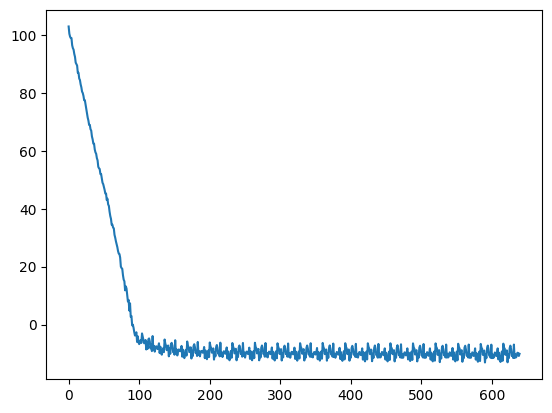

In [ ]:
from matplotlib import pyplot as plt

optimized_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/optimized_heads",
    mt.name.split("/")[-1],
    "odd_one_out__not_patch_category.npz"
)

optimization_results = np.load(optimized_path, allow_pickle=True)
plt.plot(optimization_results["losses"])
plt.show()

198

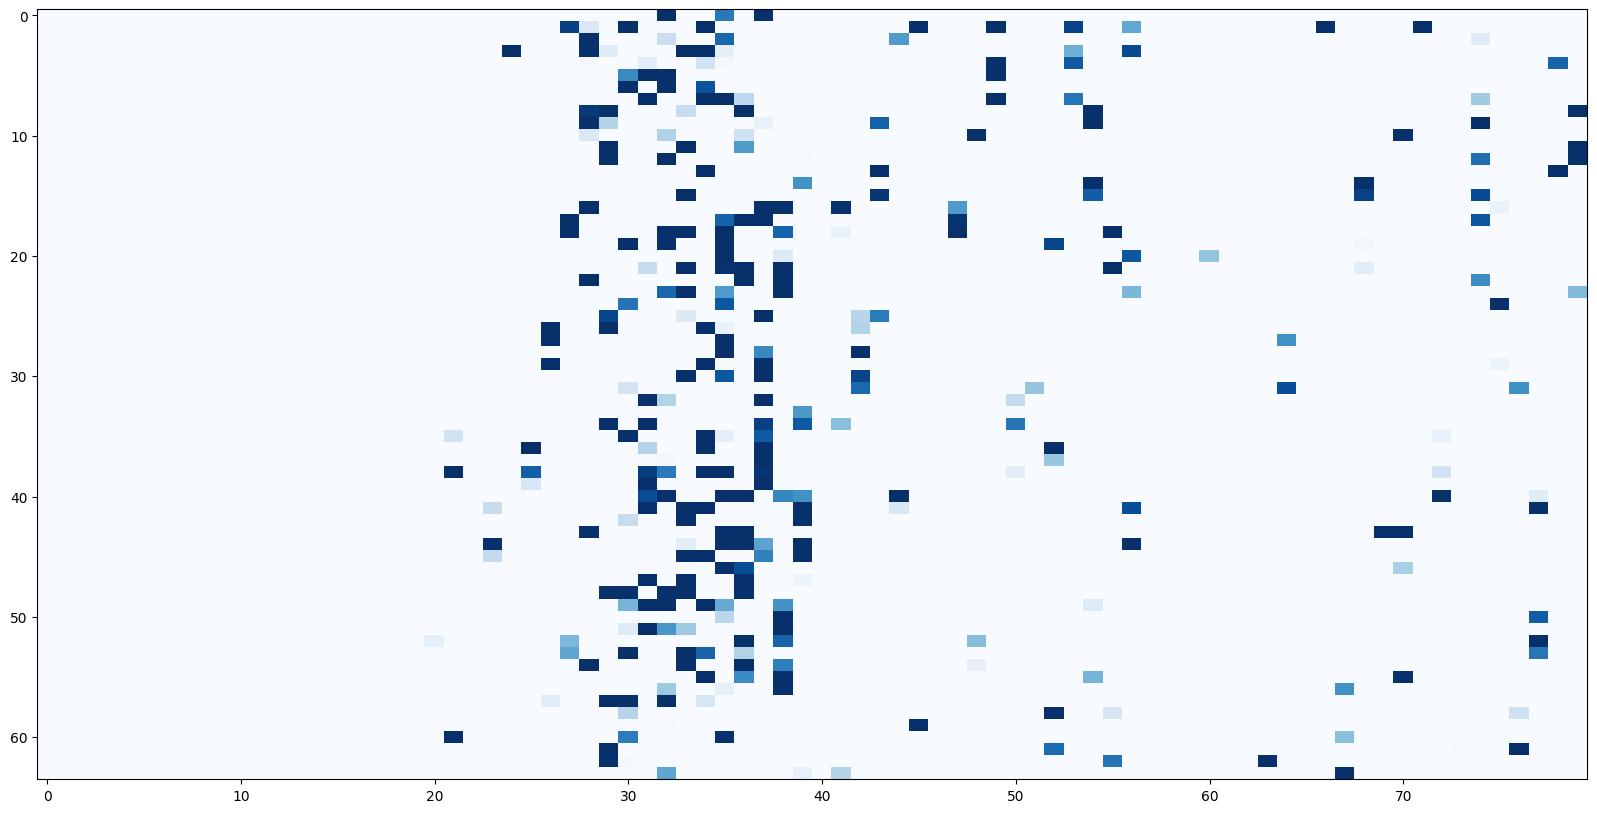

In [ ]:
plt.figure(figsize=(20, 10))
optimal_head_mask = torch.tensor(optimization_results["optimal_mask"]).to(torch.float32)
optimal_head_mask[55:, :] = 0  # Ignore the last layers, as they are not used in the task

plt.imshow(
    optimal_head_mask.T.numpy(),
    cmap="Blues",
    aspect="auto",
    vmin=0,
    vmax=1,
)

heads_selected = torch.nonzero(optimal_head_mask > 0.5, as_tuple=False).tolist()
# heads_selected = [
#     (layer_idx, head_idx) for layer_idx, head_idx in heads_selected if layer_idx < 55
# ]
len(heads_selected)

## Validation of the patching effect

In [323]:
from src.functional import free_gpu_cache
free_gpu_cache()
validation_set = []
validation_limit = 256

while len(validation_set) < validation_limit:
    samples = get_counterfactual_samples_odd_one_out(
        task=select_odd_one,
        filter_by_lm_prediction=True,
        prompt_template_idx=3,
        option_style="single_line",
        n_distractors=5
    )
    validation_set.append(samples)

2025-08-14 15:49:28 __main__ INFO     patch_sample=Trombone -> Maple (5): ['Violin', 'Piano', 'Cello', 'Guitar', 'Xylophone', 'Maple']
2025-08-14 15:49:28 __main__ INFO     not_dist_category_sample=Orange -> Coffee table (0): ['Coffee table', 'Strawberry']
2025-08-14 15:49:28 __main__ INFO     is_obj_category_sample=Museum -> Pressure cooker (1): ['Theater', 'Pressure cooker']
2025-08-14 15:49:28 __main__ INFO     Options: Violin, Piano, Cello, Guitar, Xylophone, Maple.
Which among these objects mentioned above is not a music instrument?
Answer:
2025-08-14 15:49:28 __main__ INFO     Trombone | music instrument -> Maple | pred=['" Maple"[44570] (p=0.930, logit=21.500)', '" The"[578] (p=0.015, logit=17.375)', '" Among"[22395] (p=0.007, logit=16.625)', '" MAP"[28322] (p=0.006, logit=16.500)', '" ("[320] (p=0.006, logit=16.500)']
2025-08-14 15:49:29 __main__ INFO     Options: Coffee table, Strawberry.
Which among these objects mentioned above is not a fruit?
Answer:
2025-08-14 15:49:29 __m

In [330]:
from src.selection.optimization import validate_q_proj_ie_on_sample_pair

samples = validation_set[42]
patch = samples["patch_sample"]
clean = samples["not_dist_category_sample"]
# clean = samples["is_obj_category_sample"]

print(clean.prompt(), ">>", clean.obj)
print(patch.prompt(), ">>", patch.obj)

validation_result = validate_q_proj_ie_on_sample_pair(
    mt=mt,
    clean_sample=clean,
    patch_sample=patch,
    # heads=HEADS,
    heads=heads_selected,
    query_indices=[-3, -2, -1],
    verify_head_behavior_on=-1,
)

clean_obj = clean.ans_token_id
target_obj = clean.metadata["track_type_obj_token_id"]

logger.debug(f"clean obj: {mt.tokenizer.decode(clean_obj)}")
logger.debug(f"target obj: {mt.tokenizer.decode(target_obj)}")

before_intervention = {
    "clean_rank": validation_result["clean_track"][clean_obj][0],
    "clean_logit": validation_result["clean_track"][clean_obj][1].logit,
    "target_rank": validation_result["clean_track"][target_obj][0],
    "target_logit": validation_result["clean_track"][target_obj][1].logit,
}

after_intervention = {
    "clean_rank": validation_result["int_track"][clean_obj][0],
    "clean_logit": validation_result["int_track"][clean_obj][1].logit,
    "target_rank": validation_result["int_track"][target_obj][0],
    "target_logit": validation_result["int_track"][target_obj][1].logit,
}

clean_rank_delta = before_intervention["clean_rank"] - after_intervention["clean_rank"]
target_rank_delta = (
    before_intervention["target_rank"] - after_intervention["target_rank"]
)
logger.info(
    f"Clean Prediction Rank Change: {before_intervention['clean_rank']} -> {after_intervention['clean_rank']} | Delta: {clean_rank_delta} "
)
logger.info(
    f"Target Prediction Rank Change: {before_intervention['target_rank']} -> {after_intervention['target_rank']} | Delta: {target_rank_delta} "
)

clean_logit_delta = (
    after_intervention["clean_logit"] - before_intervention["clean_logit"]
)
target_logit_delta = (
    after_intervention["target_logit"] - before_intervention["target_logit"]
)
logger.info(
    f"Clean Prediction Logit Change: {before_intervention['clean_logit']:.4f} -> {after_intervention['clean_logit']:.4f} | Delta: {clean_logit_delta:.4f} "
)
logger.info(
    f"Target Prediction Logit Change: {before_intervention['target_logit']:.4f} -> {after_intervention['target_logit']:.4f} | Delta: {target_logit_delta:.4f} "
)

Options: Daisy, Giraffe.
Which among these objects mentioned above is not a flower?
Answer: >> Giraffe
Options: Blueberry, Raspberry, Mango, Basketball, Strawberry, Pear.
Which among these objects mentioned above is not a fruit?
Answer: >> Basketball
2025-08-14 16:23:07 src.selection.optimization INFO     Verifying head behavior...
2025-08-14 16:23:07 src.selection.optimization INFO     Clean Sample >> Ans: Giraffe


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


0 patches to ablate possible answer information from options
2025-08-14 16:23:11 src.selection.functional DEBUG    Generated full answer: " Giraffe. Giraffe is an animal, not a flower. Daisy is a type of flower. Therefore, the best answer is Giraffe."
2025-08-14 16:23:11 src.selection.functional DEBUG    Predictions: ['" Gir"[48035] (p=0.930, logit=20.500)', '" The"[578] (p=0.017, logit=16.500)', '" A"[362] (p=0.010, logit=16.000)', '" ("[320] (p=0.007, logit=15.625)', '" Option"[7104] (p=0.004, logit=14.938)']
2025-08-14 16:23:11 src.selection.functional INFO     Combined attention matrix for all heads


2025-08-14 16:23:11 src.selection.optimization INFO     Patch Sample >> Ans: Basketball


The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


0 patches to ablate possible answer information from options
2025-08-14 16:23:15 src.selection.functional DEBUG    Generated full answer: " Basketball.
Explanation: Basketball is a sport, not a fruit. The other options, Blueberry, Raspberry, Mango, Strawberry, and Pear, are"
2025-08-14 16:23:15 src.selection.functional DEBUG    Predictions: ['" Basketball"[47589] (p=0.941, logit=21.750)', '" The"[578] (p=0.017, logit=17.750)', '" Basket"[34217] (p=0.007, logit=16.875)', '" A"[362] (p=0.006, logit=16.625)', '" ""[330] (p=0.003, logit=16.000)']
2025-08-14 16:23:15 src.selection.functional INFO     Combined attention matrix for all heads


2025-08-14 16:23:15 src.selection.optimization INFO     Caching the query states for the 186 heads
2025-08-14 16:23:15 src.selection.optimization INFO     patch_prediction=['" Basketball"[47589] (p=0.941, logit=21.750)', '" The"[578] (p=0.017, logit=17.750)', '" Basket"[34217] (p=0.007, logit=16.875)', '" A"[362] (p=0.006, logit=16.625)', '" ""[330] (p=0.003, logit=16.000)']
2025-08-14 16:23:15 src.selection.optimization INFO     clean run
2025-08-14 16:23:16 src.selection.optimization INFO     clean_prediction=['" Gir"[48035] (p=0.930, logit=20.500)', '" The"[578] (p=0.017, logit=16.500)', '" A"[362] (p=0.010, logit=16.000)', '" ("[320] (p=0.007, logit=15.625)', '" Option"[7104] (p=0.004, logit=14.938)']
2025-08-14 16:23:16 src.selection.optimization INFO     clean_track=OrderedDict([(48035, (1, PredictedToken(token=' Gir', prob=0.9296875, logit=20.5, token_id=48035, metadata=None))), (71264, (16, PredictedToken(token=' Daisy', prob=0.000621795654296875, logit=13.1875, token_id=71264,

2025-08-14 16:23:16 src.selection.optimization INFO     int_prediction=['" Daisy"[71264] (p=0.938, logit=21.000)', '" d"[294] (p=0.019, logit=17.125)', '" Gir"[48035] (p=0.007, logit=16.125)', '" ("[320] (p=0.005, logit=15.750)', '" Option"[7104] (p=0.004, logit=15.562)']
2025-08-14 16:23:16 src.selection.optimization INFO     int_track=OrderedDict([(71264, (1, PredictedToken(token=' Daisy', prob=0.9375, logit=21.0, token_id=71264, metadata=None))), (48035, (3, PredictedToken(token=' Gir', prob=0.007171630859375, logit=16.125, token_id=48035, metadata=None)))])
2025-08-14 16:23:16 __main__ DEBUG    clean obj:  Gir
2025-08-14 16:23:16 __main__ DEBUG    target obj:  Daisy
2025-08-14 16:23:16 __main__ INFO     Clean Prediction Rank Change: 1 -> 3 | Delta: -2 
2025-08-14 16:23:16 __main__ INFO     Target Prediction Rank Change: 16 -> 1 | Delta: 15 
2025-08-14 16:23:16 __main__ INFO     Clean Prediction Logit Change: 20.5000 -> 16.1250 | Delta: -4.3750 
2025-08-14 16:23:16 __main__ INFO    

In [319]:
from tqdm.auto import tqdm

not_patch_category_validation_set = [
    (samples["not_dist_category_sample"], samples["patch_sample"])
    for samples in validation_set
]

is_obj_category_validation_set = [
    (samples["is_obj_category_sample"], samples["patch_sample"])
    for samples in validation_set
]

validation_results = []
for clean_sample, patch_sample in tqdm(not_patch_category_validation_set):
    result = validate_q_proj_ie_on_sample_pair(
        mt=mt,
        clean_sample=clean_sample,
        patch_sample=patch_sample,
        # heads=HEADS,
        heads=heads_selected,
        query_indices=[-3, -2, -1],
        verify_head_behavior_on=None,
    )
    validation_results.append(result)
    print("=" * 80)

  0%|          | 0/256 [00:00<?, ?it/s]

2025-08-14 15:31:32 src.selection.optimization INFO     Caching the query states for the 198 heads


2025-08-14 15:31:32 src.selection.optimization INFO     patch_prediction=['" Hat"[22050] (p=0.789, logit=20.750)', '" The"[578] (p=0.083, logit=18.500)', '" A"[362] (p=0.044, logit=17.875)', '" Among"[22395] (p=0.016, logit=16.875)', '" ("[320] (p=0.006, logit=15.875)']
2025-08-14 15:31:32 src.selection.optimization INFO     clean run
2025-08-14 15:31:32 src.selection.optimization INFO     clean_prediction=['" Mall"[32498] (p=0.945, logit=21.250)', '" The"[578] (p=0.012, logit=16.875)', '" ("[320] (p=0.010, logit=16.750)', '" A"[362] (p=0.006, logit=16.250)', '" ""[330] (p=0.003, logit=15.500)']
2025-08-14 15:31:32 src.selection.optimization INFO     clean_track=OrderedDict([(32498, (1, PredictedToken(token=' Mall', prob=0.9453125, logit=21.25, token_id=32498, metadata=None))), (60413, (8, PredictedToken(token=' Uk', prob=0.00118255615234375, logit=14.5625, token_id=60413, metadata=None)))])
2025-08-14 15:31:32 src.selection.optimization INFO     patching the q_proj states
2025-08-14 1

In [263]:
before_intervention = []
after_intervention = []

for intervention_result in validation_results:
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]

    clean_obj = clean_sample.ans_token_id
    target_obj = clean_sample.metadata["track_type_obj_token_id"]

    before_intervention.append({
        "clean_rank": intervention_result["clean_track"][clean_obj][0],
        "clean_logit": intervention_result["clean_track"][clean_obj][1].logit,
        "target_rank": intervention_result["clean_track"][target_obj][0],
        "target_logit": intervention_result["clean_track"][target_obj][1].logit,
    })

    after_intervention.append({
        "clean_rank": intervention_result["int_track"][clean_obj][0],
        "clean_logit": intervention_result["int_track"][clean_obj][1].logit,
        "target_rank": intervention_result["int_track"][target_obj][0],
        "target_logit": intervention_result["int_track"][target_obj][1].logit,
    })

In [264]:
import numpy as np

clean_rank_delta = [
    after["clean_rank"] - before["clean_rank"]
    for before, after in zip(before_intervention, after_intervention)
]
target_rank_delta = [
    after["target_rank"] - before["target_rank"]
    for before, after in zip(before_intervention, after_intervention)
]

clean_rank_delta, target_rank_delta = np.array(clean_rank_delta), np.array(
    target_rank_delta
)
print(f"clean_rank_delta: {clean_rank_delta.mean():.4f} ± {clean_rank_delta.std():.4f}")
print(
    f"target_rank_delta: {target_rank_delta.mean():.4f} ± {target_rank_delta.std():.4f}"
)

clean_rank_after_intervention = [after["clean_rank"] for after in after_intervention]
clean_rank_after_intervention = np.array(clean_rank_after_intervention)
print(
    f"clean_rank_after_intervention: {clean_rank_after_intervention.mean():.4f} ± {clean_rank_after_intervention.std():.4f}"
)

target_rank_after_intervention = [after["target_rank"] for after in after_intervention]
target_rank_after_intervention = np.array(target_rank_after_intervention)
print(
    f"target_rank_after_intervention: {target_rank_after_intervention.mean():.4f} ± {target_rank_after_intervention.std():.4f}"
)

clean_rank_delta: 2426.9727 ± 3941.8905
target_rank_delta: -5.0234 ± 22.4800
clean_rank_after_intervention: 2427.9883 ± 3941.8865
target_rank_after_intervention: 3.6562 ± 19.7438


In [265]:
clean_logit_delta = [
    after["clean_logit"] - before["clean_logit"]
    for before, after in zip(before_intervention, after_intervention)
]
target_logit_delta = [
    after["target_logit"] - before["target_logit"]
    for before, after in zip(before_intervention, after_intervention)
]
clean_logit_delta, target_logit_delta = np.array(clean_logit_delta), np.array(target_logit_delta)
print(f"clean_logit_delta: {clean_logit_delta.mean():.4f} ± {clean_logit_delta.std():.4f}")
print(f"target_logit_delta: {target_logit_delta.mean():.4f} ± {target_logit_delta.std():.4f}")

clean_logit_after_intervention = [
    after["clean_logit"]
    for after in after_intervention
]
clean_logit_after_intervention = np.array(clean_logit_after_intervention)
print(f"clean_logit_after_intervention: {clean_logit_after_intervention.mean():.4f} ± {clean_logit_after_intervention.std():.4f}")

target_logit_after_intervention = [
    after["target_logit"]
    for after in after_intervention
]
target_logit_after_intervention = np.array(target_logit_after_intervention)
print(f"target_logit_after_intervention: {target_logit_after_intervention.mean():.4f} ± {target_logit_after_intervention.std():.4f}")

clean_logit_delta: -12.5025 ± 3.9188
target_logit_delta: 4.3837 ± 3.1252
clean_logit_after_intervention: 8.1511 ± 3.7575
target_logit_after_intervention: 19.9220 ± 2.7957


In [266]:
top_1 = sum([1 for after in after_intervention if after["target_rank"] == 1])
top_1 / len(after_intervention)

0.86328125

In [267]:
counter_patch_type_top_option = 0
failed_cases = []

for intervention_result in validation_results:
    clean_sample = intervention_result["clean_sample"]
    patch_sample = intervention_result["patch_sample"]
    int_track = intervention_result["int_track"]
    clean_track = intervention_result["clean_track"]
    if (
        int_track[list(int_track.keys())[0]][1].token_id
        == clean_sample.metadata["track_type_obj_token_id"]
    ): 
        counter_patch_type_top_option += 1
    else:
        failed_cases.append(
            {
                "clean_sample": clean_sample,
                "patch_sample": patch_sample,
                "int_track": int_track,
                "clean_track": clean_track,
            }
        )

top_1_accuracy = counter_patch_type_top_option / len(validation_results)
print(
    f"Counterfactual patching accuracy: {top_1_accuracy:.4f} ({counter_patch_type_top_option}/{len(validation_results)})"
)

Counterfactual patching accuracy: 0.9609 (246/256)


In [160]:
for failed_case in failed_cases[:20]:
    clean_sample = failed_case["clean_sample"]
    patch_sample = failed_case["patch_sample"]
    int_track = failed_case["int_track"]
    clean_track = failed_case["clean_track"]

    print("Clean Sample:")
    print(clean_sample.prompt(), ">>", clean_sample.obj)

    print("-" * 100)
    print(clean_sample.metadata["track_category"], ">>", clean_sample.metadata["track_type_obj"])
    print("-" * 100)

    clean_track = [pred for tok_id, (rank, pred) in clean_track.items()]
    print(f"Clean Track: {json.dumps([str(pred) for pred in clean_track], indent=4)}")

    int_track = [pred for tok_id, (rank, pred) in int_track.items()]
    print(f"Intervened Track: {json.dumps([str(pred) for pred in int_track], indent=4)}")
    print("=" * 100)


Clean Sample:
Options: Pencil, Cherry, Temple, Bamboo, Cabinet, Dishwasher.
Which among these objects mentioned above is a fruit?
Answer: >> Cherry
----------------------------------------------------------------------------------------------------
kitchen appliance >> Dishwasher
----------------------------------------------------------------------------------------------------
Clean Track: [
    "\" Cherry\"[45805] (p=0.934, logit=22.000)",
    "\" P\"[393] (p=0.005, logit=16.750)",
    "\" Temple\"[19176] (p=0.000, logit=12.562)",
    "\" Bamboo\"[98028] (p=0.000, logit=11.438)",
    "\" Dish\"[49268] (p=0.000, logit=10.125)",
    "\" Cabinet\"[34046] (p=0.000, logit=8.875)",
    "\" Ju\"[22410] (p=0.000, logit=7.250)"
]
Intervened Track: [
    "\" Cherry\"[45805] (p=0.475, logit=20.625)",
    "\" P\"[393] (p=0.420, logit=20.500)",
    "\" Dish\"[49268] (p=0.003, logit=15.500)",
    "\" Cabinet\"[34046] (p=0.002, logit=15.312)",
    "\" Temple\"[19176] (p=0.001, logit=14.625)",
    

In [102]:
mt.tokenizer.decode(failed_cases[0]["clean_sample"].metadata["track_type_obj_token_id"])

' Dish'

In [103]:
clean_sample.metadata.keys()

dict_keys(['track_category', 'track_type_obj', 'track_type_obj_idx', 'track_type_obj_token_id', 'tokenized'])